### imports

In [1]:
import numpy as np
import pandas as pd

from tqdm import tqdm
tqdm.pandas()

### load predictions

In [2]:
predictions = pd.read_csv("embryoAI_datasets/embryoAI_predictions.csv")
predictions["prediction"] = predictions.prediction.progress_apply(lambda x: x.strip("[[]]").split())
predictions["prediction"] = predictions.prediction.progress_apply(lambda x : [float(a) for a in x])
predictions[:4]

100%|██████████████████████████████████████████████████████████████████████| 137682/137682 [00:00<00:00, 138082.56it/s]


,case,frame,phase,path,flag,prediction,predicted_phase
0,DS61-1,19,tPNa,DS61-1/D2012.01.27_S0364_I132_WELL1_RUN19.jpeg,growing,"[0.00013657552, 1.6470891e-07, 1.1463476e-07, ...",tPNa
1,DS61-1,20,tPNa,DS61-1/D2012.01.27_S0364_I132_WELL1_RUN20.jpeg,growing,"[6.9838177e-05, 1.411306e-07, 5.1814305e-07, 3...",tPB2
2,DS61-1,29,tPNa,DS61-1/D2012.01.27_S0364_I132_WELL1_RUN29.jpeg,growing,"[8.6491083e-05, 1.6546151e-07, 5.0405244e-08, ...",tPB2
3,DS61-1,30,tPNa,DS61-1/D2012.01.27_S0364_I132_WELL1_RUN30.jpeg,growing,"[8.4943909e-05, 1.0639483e-07, 3.0971755e-08, ...",tPNa


In [3]:
# assume y_true and y_pred are your true and predicted labels, respectively
y_true = predictions.phase.values
y_pred = predictions.predicted_phase.values
y_pred_proba = np.array([y for y in predictions.prediction.values])
n_classes = len(set(y_true))
categories = {0: 't2',
 1: 't3',
 2: 't4',
 3: 't5',
 4: 't6',
 5: 't7',
 6: 't8',
 7: 't9+',
 8: 'tB',
 9: 'tEB',
 10: 'tHB',
 11: 'tM',
 12: 'tPB2',
 13: 'tPNa',
 14: 'tPNf',
 15: 'tSB'}
y_true_one_hot = pd.get_dummies(predictions.phase.map({v:k for k,v in categories.items()})).values

### evaluations

In [4]:
import numpy as np
from sklearn.metrics import confusion_matrix

def specificity_score(y_true, y_pred, labels=None, average='macro'):
    """
    Calculate the specificity score for each class.

    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        True labels for each sample.
    y_pred : array-like of shape (n_samples,)
        Predicted labels for each sample.
    labels : array-like of shape (n_classes,), optional
        List of labels to index the matrix. This may be used to reorder or
        select a subset of labels. If None is given, all labels are used.
    average : {'macro', 'weighted'}, optional
        Defines the method to calculate the average specificity score. If 'macro',
        then the average is calculated over all classes. If 'weighted', then the
        average is weighted by the number of samples in each class.

    Returns
    -------
    specificity : float or array-like of shape (n_classes,)
        Specificity score(s) for each class.

    References
    ----------
    https://en.wikipedia.org/wiki/Sensitivity_and_specificity

    """
    # Convert input arrays to NumPy arrays
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Calculate the number of true negatives and false positives for each class
    tn = np.sum(cm) - np.sum(cm, axis=0) - np.sum(cm, axis=1) + np.diagonal(cm)
    fp = np.sum(cm, axis=0) - np.diagonal(cm)

    # Calculate the specificity for each class
    specificity = tn / (tn + fp)

    if average == 'macro':
        # Calculate the macro-average specificity
        specificity = np.nanmean(specificity)
    elif average == 'weighted':
        # Calculate the weighted-average specificity
        n_samples = np.sum(cm)
        specificity = np.sum(specificity * np.sum(cm, axis=1)) / n_samples
    else:
        raise ValueError("Invalid average parameter: '{}'".format(average))

    return specificity


In [5]:
import numpy as np
from sklearn.metrics import (accuracy_score, recall_score, f1_score,
                             cohen_kappa_score, matthews_corrcoef)

def evaluate_model(y_true, y_pred):
    """
    Evaluate a classification model using several metrics.

    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        True labels for each sample.
    y_pred : array-like of shape (n_samples,)
        Predicted labels for each sample.

    Returns
    -------
    dict
        A dictionary of evaluation metrics, containing the following keys:
        - 'accuracy'
        - 'sensitivity'
        - 'specificity'
        - 'f1_score'
        - 'cohen_kappa'
        - 'mcc'

    """
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    sensitivity = recall_score(y_true, y_pred, average="macro")
    specificity = specificity_score(y_true, y_pred)
    f_score = f1_score(y_true, y_pred, average="macro")
    cohen_kappa = cohen_kappa_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)

    # Create a dictionary of evaluation metrics
    eval_dict = {
        'accuracy': accuracy,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'f1_score': f_score,
        'cohen_kappa': cohen_kappa,
        'mcc': mcc
    }

    return eval_dict

evaluate_model(y_true, y_pred)

{'accuracy': 0.7070423148995512,
 'sensitivity': 0.5863098954495354,
 'specificity': 0.979564514759182,
 'f1_score': 0.6116384213415672,
 'cohen_kappa': 0.6719372344187282,
 'mcc': 0.673295853161877}

Each metric in a classification evaluation report provides different information about the performance of the model. Here is a brief summary of the significance of each metric:

    Accuracy: Measures the overall correctness of the model's predictions. This metric is useful when all classes are equally important and balanced in the dataset. However, when the dataset is imbalanced, accuracy can be misleading as it may give high scores even when the model performs poorly on minority classes.

    Sensitivity (also known as recall or true positive rate): Measures the proportion of actual positives that are correctly classified by the model. This metric is useful when the cost of a false negative is high. For example, in medical diagnosis, it is important to correctly identify all patients with a disease to prevent its spread.

    Specificity: Measures the proportion of actual negatives that are correctly classified by the model. This metric is useful when the cost of a false positive is high. For example, in spam detection, it is important to avoid false positives (classifying a non-spam message as spam) to avoid deleting important messages.

    F1-score: The harmonic mean of precision and recall. It provides a balance between precision (the proportion of predicted positives that are actually positive) and recall (the proportion of actual positives that are correctly classified). This metric is useful when there is a trade-off between precision and recall and both are important. For example, in fraud detection, it is important to correctly identify all fraudulent transactions while avoiding false accusations.

    Cohen's kappa: Measures the agreement between the predicted labels and the true labels, taking into account the agreement that could be expected by chance. This metric is useful when evaluating the consistency of the model's predictions with the true labels.

    Matthews correlation coefficient (MCC): A metric that takes into account both true and false positives and negatives and is generally considered to be more informative than accuracy when the classes are imbalanced. This metric ranges from -1 to 1, where 1 represents a perfect prediction, 0 represents a random prediction, and -1 represents a perfectly wrong prediction.

### multiclass evaluations (using 1vAll approach)

In [6]:
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score, average_precision_score, cohen_kappa_score

def multiclass_evaluations(y_true_one_hot, y_pred_proba, categories, threshold=0.5):
    """
    Computes and returns a DataFrame containing various evaluation metrics for a multiclass classification problem.

    Parameters
    ----------
    y_true_one_hot : numpy.ndarray
        A 2D numpy array of shape (n_samples, n_classes) containing the true labels in one-hot encoded format.
    y_pred_proba : numpy.ndarray
        A 2D numpy array of shape (n_samples, n_classes) containing the predicted class probabilities for each sample.
    categories : dict
        A dictionary that maps the class index (integer) to the class label (string).
    threshold : float, optional (default=0.5)
        The probability threshold to use when converting the predicted probabilities to binary labels.

    Returns
    -------
    pandas.DataFrame
        A DataFrame containing the following evaluation metrics for each class:
        - Accuracy
        - Precision
        - Recall
        - F1-score
        - MCC (Matthews correlation coefficient)
        - ROC AUC
        - PRC AUC (area under the precision-recall curve)
        - Cohen's kappa
        - TP rate (true positive rate or sensitivity)
        - FP rate (false positive rate)
        - Specificity

    """
    accuracies = dict()
    precisions = dict()
    recalls = dict()
    f1_scores = dict()
    mccs = dict()
    roc_aucs = dict()
    prc_aucs = dict()
    kappas = dict()
    tprs = dict()
    fprs = dict()
    specificities = dict()
    
    for idx, c_label in categories.items():
        y_pred_binary = (y_pred_proba[:, idx] >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true_one_hot[:, idx], y_pred_binary).ravel()
        
        # calculate metrics
        accuracies[c_label] = accuracy_score(y_true_one_hot[:, idx], y_pred_binary)
        precisions[c_label] = precision_score(y_true_one_hot[:, idx], y_pred_binary, average='binary')
        recalls[c_label] = recall_score(y_true_one_hot[:, idx], y_pred_binary, average='binary')
        f1_scores[c_label] = f1_score(y_true_one_hot[:, idx], y_pred_binary, average='binary')
        mccs[c_label] = matthews_corrcoef(y_true_one_hot[:, idx], y_pred_binary)
        roc_aucs[c_label] = roc_auc_score(y_true_one_hot[:, idx], y_pred_proba[:, idx])
        prc_aucs[c_label] = average_precision_score(y_true_one_hot[:, idx], y_pred_proba[:, idx])
        kappas[c_label] = cohen_kappa_score(y_true_one_hot[:, idx], y_pred_binary)
        
        # calculate TP rate, FP rate, and specificity
        if tp+fn > 0:
            tpr = tp / (tp+fn)
        else:
            tpr = 0
        if fp+tn > 0:
            fpr = fp / (fp+tn)
        else:
            fpr = 0
        if tn+fp > 0:
            specificity = tn / (tn+fp)
        else:
            specificity = 0
            
        # store metrics in dictionaries
        tprs[c_label] = tpr
        fprs[c_label] = fpr
        specificities[c_label] = specificity
        
    # create dataframe
    evaluations = pd.DataFrame({'Accuracy': accuracies, 'Precision': precisions, 'Recall': recalls,
                                'F1-score': f1_scores, 'MCC': mccs, 'ROC AUC': roc_aucs, 'PRC AUC': prc_aucs,
                                'Cohen\'s kappa': kappas, 'TP rate': tprs, 'FP rate': fprs, 'Specificity': specificities})
    
    # add row for average scores
    evaluations.loc['Average'] = evaluations.mean()
    
    return evaluations


multiclass_evaluations(y_true_one_hot, y_pred_proba, categories)

,Accuracy,Precision,Recall,F1-score,MCC,ROC AUC,PRC AUC,Cohen's kappa,TP rate,FP rate,Specificity
t2,0.964019,0.806223,0.839476,0.822514,0.802706,0.981783,0.882316,0.802503,0.839476,0.022249,0.977751
t3,0.984762,0.942029,0.111016,0.198625,0.320607,0.962817,0.475519,0.195740,0.111016,0.000118,0.999882
t4,0.941452,0.725842,0.652520,0.687231,0.656165,0.964834,0.757421,0.655035,0.652520,0.026952,0.973048
t5,0.976729,0.839339,0.152899,0.258677,0.352458,0.954178,0.495572,0.252560,0.152899,0.000798,0.999202
t6,0.973867,0.889868,0.102227,0.183386,0.296652,0.936283,0.463781,0.178527,0.102227,0.000374,0.999626
t7,0.969626,0.844181,0.175410,0.290465,0.376754,0.944334,0.526651,0.281705,0.175410,0.001190,0.998810
t8,0.931211,0.727047,0.587189,0.649676,0.616311,0.956573,0.738971,0.612016,0.587189,0.026865,0.973135
t9+,0.918239,0.795024,0.698537,0.743664,0.697328,0.959518,0.840620,0.695268,0.698537,0.036831,0.963169
tB,0.977601,0.830312,0.448822,0.582679,0.600994,0.982975,0.731271,0.572220,0.448822,0.003311,0.996689
tEB,0.976446,0.841487,0.785099,0.812316,0.800314,0.992368,0.905149,0.799766,0.785099,0.010269,0.989731


The reason why the average accuracy calculated using the multiclass_evaluations function can be different from the accuracy calculated with all classes simultaneously is because the two methods calculate accuracy in different ways.

In the multiclass_evaluations function, accuracy is calculated separately for each class and then averaged. This means that the accuracy for each class is weighted equally in the average, regardless of the class distribution in the dataset. On the other hand, when calculating accuracy for all classes simultaneously, the true positives, true negatives, false positives, and false negatives are summed across all classes before calculating the accuracy. This means that the accuracy is weighted by the number of samples in each class, so classes with more samples will have a greater impact on the overall accuracy.

Therefore, if the class distribution in the dataset is uneven, the two methods may yield different results. The average accuracy calculated using the multiclass_evaluations function may be a better metric for evaluating the model's performance on individual classes, while the accuracy calculated for all classes simultaneously may be a better metric for evaluating the model's overall performance.

### confusion matrix

<AxesSubplot:>

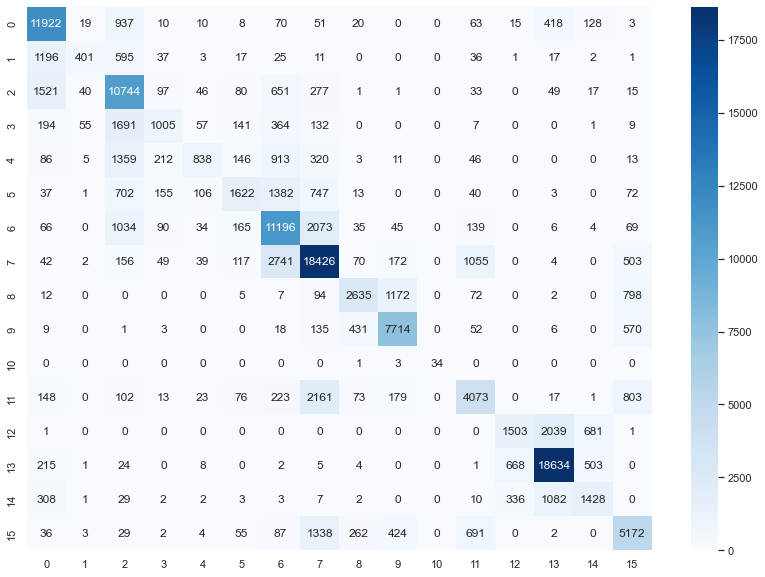

In [7]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, figsize=(14, 10)):
    """
    Calculates and plots the confusion matrix for a given set of true and predicted labels.

    Parameters:
    y_true (array-like): True labels for each sample.
    y_pred (array-like): Predicted labels for each sample.

    Returns:
    None
    """

    # calculate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # plot confusion matrix using seaborn
    sns.set(rc={'figure.figsize': figsize})
    cm_plot = sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
    
    return cm_plot

plot_confusion_matrix(y_true, y_pred)

### precision recall curve

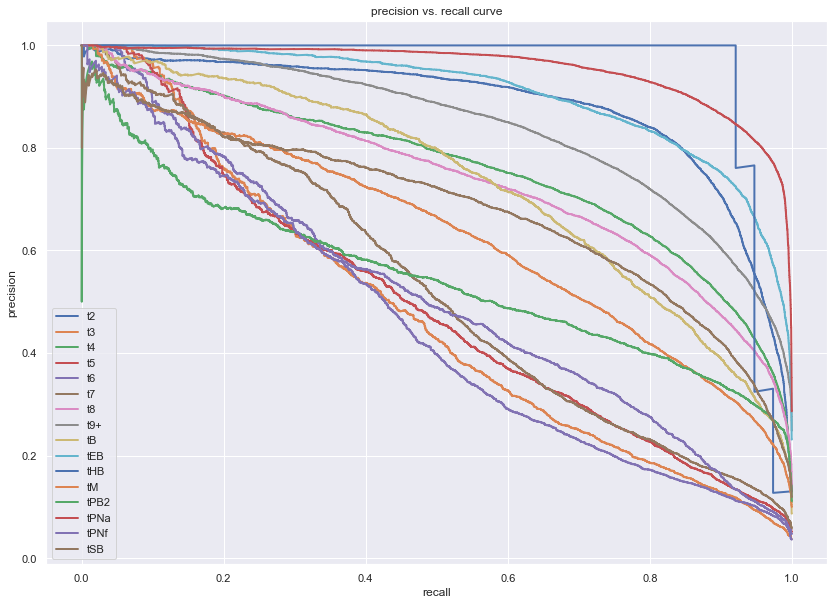

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

def precision_recall_curve_multiclass(y_true_one_hot, y_pred_proba, categories, figsize=None):
    """
    Computes and plots the precision-recall curve for multi-class classification problems.

    Parameters:
    y_true_one_hot (array-like): One-hot encoded true labels for each sample, shape (n_samples, n_classes).
    y_pred_proba (array-like): Predicted class probabilities for each sample, shape (n_samples, n_classes).
    n_classes (int): Number of classes.

    Returns:
    None
    """

    precision = dict()
    recall = dict()

    for (idx, c_label) in categories.items():
        precision[idx], recall[idx], _ = precision_recall_curve(y_true_one_hot[:, idx], y_pred_proba[:, idx])
        plt.plot(recall[idx], precision[idx], lw=2, label=c_label)

    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend(loc="best")
    plt.title("precision vs. recall curve")
    plt.show()

precision_recall_curve_multiclass(y_true_one_hot, y_pred_proba, categories)

### multi-class roc auc scores

In [9]:
roc_auc_score(y_true_one_hot, y_pred_proba, average="macro")

0.9686456000467454

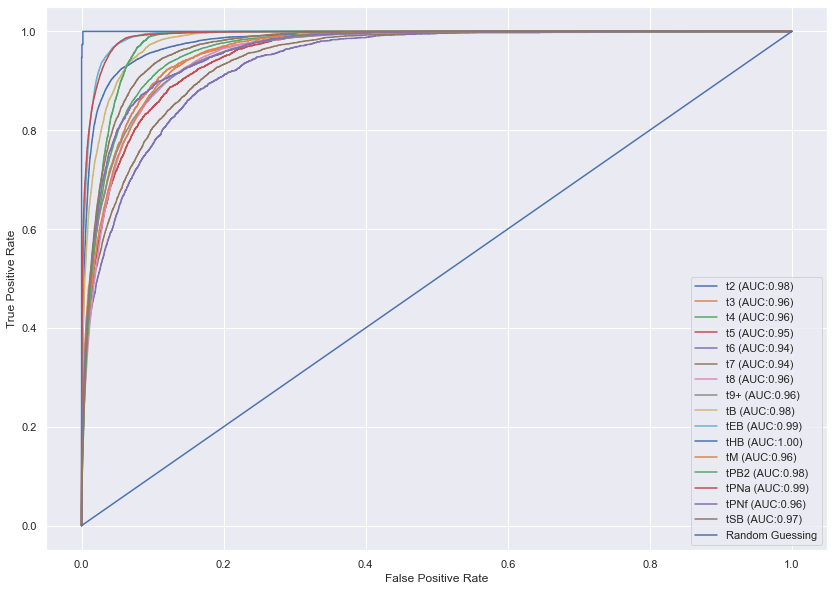

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc

def roc_auc_score_multiclass(y_true_one_hot, y_pred_proba, categories, figsize=None):
    """
    Computes and plots the Receiver Operating Characteristic (ROC) curve for multi-class classification problems.

    Parameters:
    y_true_one_hot (array-like): One-hot encoded true labels for each sample, shape (n_samples, n_classes).
    y_pred_proba (array-like): Predicted class probabilities for each sample, shape (n_samples, n_classes).
    categories (list): List of class names in order of the columns of y_true_one_hot and y_pred_proba.
    figsize (tuple): Optional figure size for the plot.
    average (str): Optional parameter for the method of averaging the AUC scores. Can be one of "macro" (default), "micro", or "weighted".

    Returns:
    float: The overall ROC AUC score based on the true labels and predicted probabilities.

    """
    # set plot figure size
    fig, c_ax = plt.subplots(1,1, figsize = figsize)
    
    for (idx, c_label) in categories.items():
        fpr, tpr, thresholds = roc_curve(y_true_one_hot[:,idx], y_pred_proba[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    plt.show()
    plt.close()

roc_auc_score_multiclass(y_true_one_hot, y_pred_proba, categories)

### investigate visually

In [14]:
samples = predictions[["path", "phase", "predicted_phase"]].sample(16)

In [15]:
import os
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import seaborn as sns
import matplotlib.pyplot as plt

def investigate_visually(samples, num_rows=4, num_cols=4, figsize=(14, 12), plot_title="visual investigation of trues/preds"):
    """
    Displays a grid of images along with their true and predicted labels.

    Parameters:
    -----------
    samples : pandas.DataFrame
        A DataFrame with columns "filename", "true_label", and "pred_label".
    num_rows : int, optional (default=4)
        The number of rows in the image grid.
    num_cols : int, optional (default=4)
        The number of columns in the image grid.
    fig_size : tuple, optional (default=None)
        The size of the figure in inches, as a tuple (width, height).
    plot_title : str, optional (default=None)
        The title of the plot.

    Returns:
    --------
    None
    """
    with sns.axes_style("whitegrid"):
        sns.set_context("notebook", font_scale=1.1)
        sns.set_style({"font.sans-serif": ["Verdana", "Arial", "Calibri", "DejaVu Sans"]})

        f, ax = plt.subplots(num_rows, num_cols, figsize=figsize, gridspec_kw={"wspace": 0.02, "hspace": 0.25}, squeeze=True)
        f.subplots_adjust(top=0.93)
        
        for r in range(num_rows):
            for c in range(num_cols):
                image_index = r * num_cols + c
                ax[r, c].axis("off")
                
                # show selected image
                image_path = os.path.join("embryoAI_images", samples.values[image_index][0])
                pil_image = Image.open(image_path)
                ax[r, c].imshow(pil_image)

                # check if prediction matches actual value
                true_label = samples.values[image_index][1]
                pred_label = samples.values[image_index][2]
                prediction_matches_true = (true_label == pred_label)
                if prediction_matches_true:
                    # if actual == prediction, cell title is prediction shown in green font
                    title = true_label
                    title_color = 'g'
                else:
                    # if actual != prediction, cell title is actual/prediction in red font
                    title = '%s/%s' % (true_label, pred_label)
                    title_color = 'r'
                # display cell title
                title = ax[r, c].set_title(title)
                plt.setp(title, color=title_color)
        # set plot title, if one specified
        if plot_title is not None:
            f.suptitle(plot_title)

        plt.show()
        plt.close()

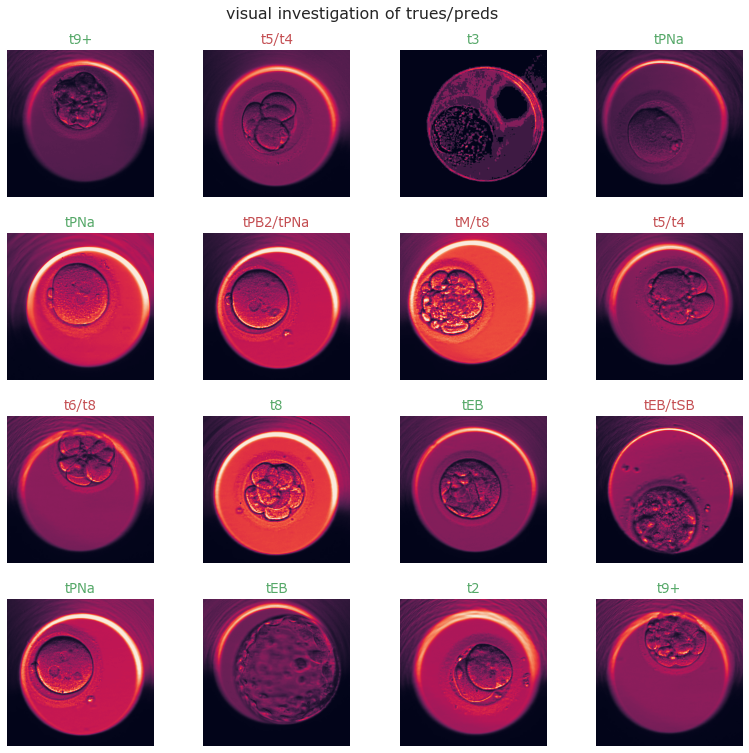

In [16]:
investigate_visually(samples)